In [7]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from nltk import pos_tag, word_tokenize
from wordcloud import WordCloud
import zipfile
import matplotlib.pyplot as plt

In [2]:
# Download NLTK resources if not already downloaded
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')  # Download for better lemmatization support
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /home/kostas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/kostas/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/kostas/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/kostas/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /home/kostas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### IMPORTANT NOTE HERE
After we performed text lemmatization on Computerome, we get an output file named "final_cleaned_dataset.tsv". This file needs to be manually moved in the folder where all the scripts live. This file will need to be merged back with "waiting_for_merge.tsv.gz" to get the information from the columns that weren't part of the file uploaded to Computerome.

In [ ]:
# Specify file names
computerome_output_file = "final_cleaned_dataset.tsv"
waiting_dataset_file = "waiting_for_merge.tsv.gz"

# Read the files
computerome_output = pd.read_csv(computerome_output_file, sep="\t", header=None)
waiting_dataset = pd.read_csv(waiting_dataset_file, sep="\t", compression="gzip")

# Add the headers to the computerome output
computerome_output.columns = ['body', 'unique_id', 'cleaned_body']

# Merge back to the original dataframe
depression = waiting_dataset.merge(computerome_output[['unique_id', 'cleaned_body']], on='unique_id', how='left')
depression
depression.to_csv("merged.tsv.gz", sep='\t', index=False, compression='gzip', header=True)

In [4]:
merged_file = "merged.tsv"
depression = pd.read_csv(merged_file, sep='\t')
depression.head()

/tmp/ipykernel_7168/3426556005.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  depression = pd.read_csv(merged_file, sep='\t')


,Unnamed: 0,subreddit,title,body,upvotes,num_comments,label,created_datetime,unique_id,cleaned_body
0,47951,DeepThoughts,Deep thoughts underdog,"Only when we start considering ourselves, the ...",4.0,0,0.0,2014-07-14 03:35:09,0,start consider 99 underdog begin value start root
1,47952,DeepThoughts,"I like this sub, there's only two posts yet I ...",Anyway: Human Morality is a joke so long as th...,4.0,1,0.0,2014-09-13 00:31:19,1,anyway human morality joke long abscence hope ...
2,47957,DeepThoughts,Rebirth!,Hello. I am the new guy in charge here (Beside...,6.0,1,0.0,2014-11-20 04:31:58,2,hello new guy charge besides thegood ofc bring...
3,47960,DeepThoughts,Who am I?,You could take any one cell in my body and kil...,5.0,4,0.0,2014-11-20 20:36:52,3,could take one cell body kill would still yet ...
4,47969,DeepThoughts,What is the limit of the knowledge and power a...,"Personally, I think it's infinite. We will alw...",8.0,23,0.0,2014-11-22 19:17:39,4,personally think infinite always grow


Some last pre-processing before we can use our data set for further analysis and model generation and implementation

In [5]:
# Check how many rows have NaN values in any of the columns
num_rows = len(depression)
print("Columns in the dataset:", depression.columns.tolist())

# Drop NAs in body and title
depression = depression.dropna(subset=['body'])
depression = depression.dropna(subset=['title'])
depression = depression.dropna(subset=['label'])

# Drop columns that we will not use 
depression = depression.drop(columns=['upvotes', 'num_comments', 'created_datetime'])
print(f"Total number of rows: {num_rows}")

num_rows_with_na = depression.isna().any(axis=1).sum()
print(f"Number of rows with NaN values in any column: {num_rows_with_na}")

# Print the number of NaN values in each column
na_counts = depression.isna().sum()
print("Number of NaN values in each column:")
print(na_counts)

# Define the list of actual subreddit names you want to keep
valid_subreddits = [
    'DeepThoughts', 'teenagers', 'SuicideWatch', 'depression', 'happy'
    # Add any other subreddits you recognize as valid
]

# Filter the DataFrame to keep only rows with valid subreddit names
filtered_depression = depression[depression['subreddit'].isin(valid_subreddits)]

Columns in the dataset: ['Unnamed: 0', 'subreddit', 'title', 'body', 'upvotes', 'num_comments', 'label', 'created_datetime', 'unique_id', 'cleaned_body']
Total number of rows: 2000382
Number of rows with NaN values in any column: 0
Number of NaN values in each column:
Unnamed: 0      0
subreddit       0
title           0
body            0
label           0
unique_id       0
cleaned_body    0
dtype: int64


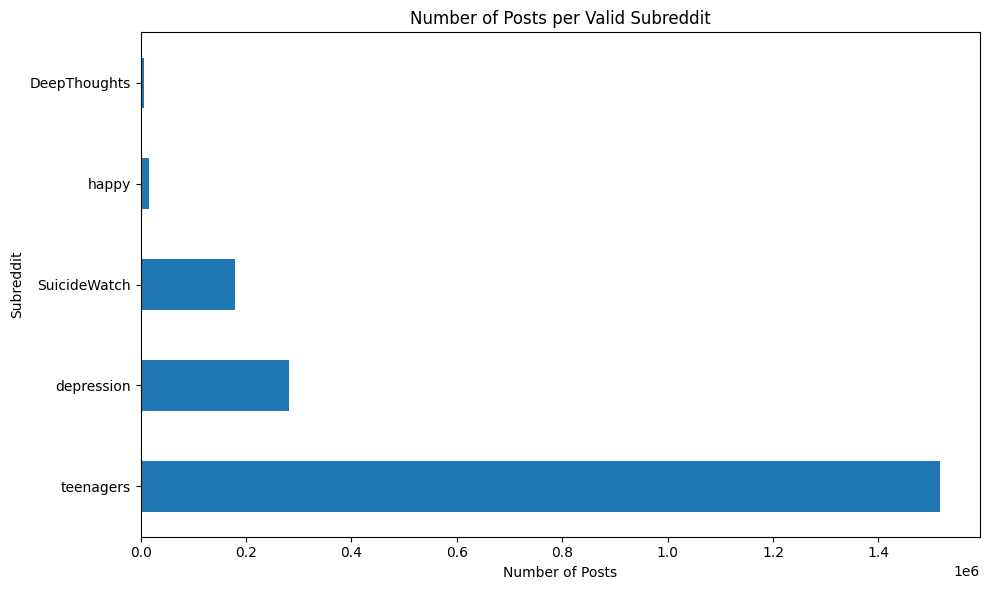

In [13]:
# Count the number of posts per subreddit
subreddit_counts = filtered_depression['subreddit'].value_counts()

# Plot the horizontal bar chart
plt.figure(figsize=(10, 6))
subreddit_counts.plot(kind='barh')
plt.title('Number of Posts per Valid Subreddit')
plt.xlabel('Number of Posts')
plt.ylabel('Subreddit')
plt.tight_layout()  # Adjust layout to fit everything nicely
plt.savefig('valid_subreddits_horizontal_bar_plot.png')  # Optional: Save the plot
plt.show()


Write the final processed dataset

In [ ]:
filtered_depression.to_csv("use_this_one.tsv.gz", sep='\t', index=False, compression='gzip')